In [11]:
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action='ignore')


# 0. 데이터 로드

In [13]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings

def percentile(s):
    return round(np.sum(s) / len(s)*100, 2)

def avgLV(data):
    tags = data['KnowledgeTag'].unique()
    LV = []
    
    for tid in tags:
        LV.append(data[data['KnowledgeTag']==tid]['userLVbyTag'].iloc[0])
    return round(np.mean(LV))

warnings.filterwarnings(action='ignore') # CopyWarning 출력 무시 

In [14]:
# 0. 데이터 로드
print(f'[DEBUG]] Loading Data ...')
df = pd.read_csv('/opt/ml/input/data/FE_total_data.csv')
train = df[df['answerCode']>=0]
print(f'[INFO] Total Data: {len(df)}')
print(f'[INFO] Feature Engineering Data (only answerCode >= 0): {len(train)}')
# 1. 태그별 정답률 & 유저별 태그 정답률
print(f'[DEBUG] Calculating correct tagRatio and userBytagRatio ...')
train['tagRatio'] = train.groupby('KnowledgeTag').answerCode.transform(percentile)
train['userBytagRatio'] = train.groupby(['userID', 'KnowledgeTag']).answerCode.transform(percentile)
# 2.유저별 정답률
print(f'[DEBUG] Calculating correct userRatio ...')
train['userRatio'] = train.groupby('userID').answerCode.transform(percentile)
print(f'[INFO] Done!!\n')

feature_by_test = train.drop(['assessmentItemID', 'Timestamp', 'testId', 'answerCode'], axis=1)

[DEBUG]] Loading Data ...
[INFO] Total Data: 2526700
[INFO] Feature Engineering Data (only answerCode >= 0): 2525956
[DEBUG] Calculating correct tagRatio and userBytagRatio ...
[DEBUG] Calculating correct userRatio ...
[INFO] Done!!



In [15]:
# Tag LV
tag_mean_ratio = round(feature_by_test.groupby('KnowledgeTag').mean()['tagRatio'].mean(), 2)
diff =  feature_by_test['tagRatio'] - tag_mean_ratio
pre_std = int(diff.min()//10)*10
last_std = int(diff.max()//10+1)*10
LV = (last_std - pre_std)//10

print('[INFO] Labeling for Tag Level...')
print(f'[INFO] tag mean ratio: {tag_mean_ratio}%')
print(f'[INFO] diff min({round(diff.min(), 2)}%), diff max({round(diff.max(), 2)}%)\n')

for std in tqdm(range(pre_std+10, last_std+1, 10)):
    print(f'[DEBUG] {pre_std:3d}% < diff <= {std:3d}%  |  Level: {LV}')
    idx = (pre_std < diff) & (diff <= std)
    feature_by_test.loc[idx, 'tagLV'] = LV
    pre_std = std
    LV -= 1

print()
print('[INFO] Done!!')
print(f'[INFO] Check all Tag Level: {sorted(feature_by_test["tagLV"].unique())}\n')

100%|██████████| 9/9 [00:00<00:00, 75.80it/s]

[INFO] Labeling for Tag Level...
[INFO] tag mean ratio: 61.61%
[INFO] diff min(-44.01%), diff max(35.68%)

[DEBUG] -50% < diff <= -40%  |  Level: 9
[DEBUG] -40% < diff <= -30%  |  Level: 8
[DEBUG] -30% < diff <= -20%  |  Level: 7
[DEBUG] -20% < diff <= -10%  |  Level: 6
[DEBUG] -10% < diff <=   0%  |  Level: 5
[DEBUG]   0% < diff <=  10%  |  Level: 4
[DEBUG]  10% < diff <=  20%  |  Level: 3
[DEBUG]  20% < diff <=  30%  |  Level: 2
[DEBUG]  30% < diff <=  40%  |  Level: 1

[INFO] Done!!
[INFO] Check all Tag Level: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]



In [16]:
# User LV by Tag
diff =  feature_by_test['userBytagRatio'] - feature_by_test['tagRatio']
pre_std = int(diff.min()//10)*10
last_std = int(diff.max()//10+1)*10
LV = 1

print('[INFO] Labeling for User Level by Tag...')
print(f'[INFO] diff min({round(diff.min(), 2)}%), diff max({round(diff.max(), 2)}%)\n')

for std in tqdm(range(pre_std+10, last_std+1, 10)):
    print(f'[DEBUG] {pre_std:3d}% < diff <= {std:3d}%  |  Level: {LV}')
    idx = (pre_std < diff) & (diff <= std)
    feature_by_test.loc[idx, 'userLV'] = LV
    pre_std = std
    LV += 1

print()
print('[INFO] Done!!')
print(f'[INFO] Check all User Level: {sorted(feature_by_test["userLV"].unique())}\n')

 53%|█████▎    | 10/19 [00:00<00:00, 93.25it/s]

[INFO] Labeling for User Level by Tag...
[INFO] diff min(-97.29%), diff max(82.4%)

[DEBUG] -100% < diff <= -90%  |  Level: 1
[DEBUG] -90% < diff <= -80%  |  Level: 2
[DEBUG] -80% < diff <= -70%  |  Level: 3
[DEBUG] -70% < diff <= -60%  |  Level: 4
[DEBUG] -60% < diff <= -50%  |  Level: 5
[DEBUG] -50% < diff <= -40%  |  Level: 6
[DEBUG] -40% < diff <= -30%  |  Level: 7
[DEBUG] -30% < diff <= -20%  |  Level: 8
[DEBUG] -20% < diff <= -10%  |  Level: 9
[DEBUG] -10% < diff <=   0%  |  Level: 10
[DEBUG]   0% < diff <=  10%  |  Level: 11
[DEBUG]  10% < diff <=  20%  |  Level: 12
[DEBUG]  20% < diff <=  30%  |  Level: 13
[DEBUG]  30% < diff <=  40%  |  Level: 14
[DEBUG]  40% < diff <=  50%  |  Level: 15
[DEBUG]  50% < diff <=  60%  |  Level: 16


100%|██████████| 19/19 [00:00<00:00, 89.68it/s]

[DEBUG]  60% < diff <=  70%  |  Level: 17
[DEBUG]  70% < diff <=  80%  |  Level: 18
[DEBUG]  80% < diff <=  90%  |  Level: 19

[INFO] Done!!
[INFO] Check all User Level: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0]



In [17]:
print('[DEBUG] Labeling for Total User Level (tagLV x userLV) ...')
feature_by_test['userLVbyTag'] = feature_by_test['tagLV']*feature_by_test['userLV']
print('[INFO] Done!!')
print(f'[INFO] Num of User Level: {len(feature_by_test["userLVbyTag"].unique())}')
print(f'[INFO] Check all User Level: {sorted(feature_by_test["userLVbyTag"].unique())}\n')

warnings.filterwarnings(action='default')

[DEBUG] Labeling for Total User Level (tagLV x userLV) ...
[INFO] Done!!
[INFO] Num of User Level: 67
[INFO] Check all User Level: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 14.0, 15.0, 16.0, 18.0, 20.0, 21.0, 22.0, 24.0, 25.0, 27.0, 28.0, 30.0, 32.0, 33.0, 35.0, 36.0, 39.0, 40.0, 42.0, 44.0, 45.0, 48.0, 49.0, 50.0, 52.0, 54.0, 55.0, 56.0, 60.0, 63.0, 64.0, 65.0, 66.0, 70.0, 72.0, 75.0, 77.0, 78.0, 80.0, 81.0, 84.0, 88.0, 90.0, 91.0, 96.0, 98.0, 104.0, 105.0, 112.0, 119.0, 120.0, 126.0, 136.0, 144.0, 171.0]



In [18]:
print(f'[DEBUG] Labeling for User Average Level ...')
user_grouby = feature_by_test.groupby('userID').apply(avgLV)
for uid in tqdm(user_grouby.index):
    feature_by_test.loc[feature_by_test['userID']==uid, 'userLVbyTagAVG'] = user_grouby.iloc[uid]
levels = feature_by_test['userLVbyTagAVG'].unique()
print(f'[INFO] Done!!')
print(f'[INFO] Num of User AVG Levels: {len(levels)}')
print(f'[INFO] Level(min): {min(levels)}, Level(max): {max(levels)}')
print(f'[INFO] Check all User AVG Level: {sorted(levels)}\n')

[DEBUG] Labeling for User Average Level ...


100%|██████████| 7442/7442 [00:20<00:00, 363.27it/s]

[INFO] Done!!
[INFO] Num of User AVG Levels: 72
[INFO] Level(min): 11.0, Level(max): 91.0
[INFO] Check all User AVG Level: [11.0, 12.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 84.0, 91.0]



In [24]:
len(feature_by_test['userLVbyTag'].unique())

67

In [19]:
print(f'[DEBUG] Merge with Original Dataset ...')
idx = feature_by_test.index
columns = ['tagLV', 'userLVbyTagAVG', 'userLVbyTag']
for column in tqdm(columns):
    df.loc[idx, column] = feature_by_test[column]

 33%|███▎      | 1/3 [00:00<00:00,  5.54it/s]

[DEBUG] Merge with Original Dataset ...


100%|██████████| 3/3 [00:00<00:00,  5.67it/s]


In [20]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,dataset,tagLV,userLVbyTagAVG,userLVbyTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,1.0,49.0,11.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,1.0,49.0,11.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,1,1.0,49.0,11.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,1,1.0,49.0,11.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,1,1.0,49.0,11.0
...,...,...,...,...,...,...,...,...,...,...
2526695,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,1,4.0,38.0,24.0
2526696,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1,4.0,38.0,52.0
2526697,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,1,4.0,38.0,52.0
2526698,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,1,4.0,38.0,52.0


In [21]:
df['userLVbyTag'].unique()

array([ 11.,  33.,  14.,  24.,  39.,  56.,  72.,  36.,  45.,  75.,  48.,
        40.,  60.,  55.,  20.,  54.,  25.,  30.,  50.,  65.,  66.,  84.,
        44.,  42.,  28.,  70.,  77.,  16.,  90.,  96.,  49.,  52.,  22.,
        91.,  63.,   4.,  78.,  80.,  98., 119., 112.,  64., 105.,  27.,
        35.,  18.,  21.,  32.,  12.,   9.,  nan, 136.,  10.,  15.,   8.,
       144.,  81., 171.,   6., 120., 104.,   1.,   3., 126.,   2.,   7.,
        88.,   5.])

In [25]:
df[df['answerCode']<0]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,dataset,tagLV,userLVbyTagAVG,userLVbyTag
2989,3,A050133008,A050000133,-1,2020-10-26 13:13:57,5289,2,NaN,NaN,NaN
3660,4,A070146008,A070000146,-1,2020-12-27 02:47:54,9080,2,NaN,NaN,NaN
10860,13,A070111008,A070000111,-1,2020-12-27 04:35:09,9660,2,NaN,NaN,NaN
15278,17,A090064006,A090000064,-1,2020-10-30 05:48:37,2611,2,NaN,NaN,NaN
23531,26,A060135007,A060000135,-1,2020-10-23 11:44:18,1422,2,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2525938,7395,A040122005,A040000122,-1,2020-09-08 02:05:20,10615,2,NaN,NaN,NaN
2526081,7404,A030111005,A030000111,-1,2020-10-13 09:49:18,7636,2,NaN,NaN,NaN
2526282,7416,A050193004,A050000193,-1,2020-10-04 02:44:41,10402,2,NaN,NaN,NaN
2526297,7417,A050193004,A050000193,-1,2020-09-06 13:09:15,10402,2,NaN,NaN,NaN


In [36]:
df[(df['userID']==385)&(df['KnowledgeTag']==9075)]['userLVbyTag']

313537   NaN
Name: userLVbyTag, dtype: float64

In [34]:
test = df[df['answerCode']<0]
idx_list = []
for idx in tqdm(test.index):
    uid = test.loc[idx, 'userID']
    tagid = test.loc[idx, 'KnowledgeTag']
    if np.isnan(df[(df['userID']==uid)&(df['KnowledgeTag']==tagid)]['userLVbyTag'].iloc[0]):
        idx_list.append((uid, tagid))
idx_list

100%|██████████| 744/744 [00:05<00:00, 146.45it/s]


[(385, 9075),
 (499, 4967),
 (616, 9125),
 (617, 9125),
 (694, 9926),
 (794, 9075),
 (991, 9122),
 (1044, 9125),
 (1295, 7172),
 (1331, 2118),
 (1390, 9125),
 (1628, 10841),
 (1783, 8421),
 (2162, 1875),
 (2187, 1875),
 (2282, 9125),
 (3198, 9075),
 (3268, 9075),
 (3466, 9075),
 (3533, 9125),
 (3679, 7172),
 (3754, 9125),
 (3872, 9125),
 (3981, 7862),
 (4586, 435),
 (4870, 9125),
 (4887, 1875),
 (4969, 9125),
 (5704, 10841),
 (5744, 9090),
 (5780, 2118),
 (5885, 8244),
 (5977, 435),
 (6119, 435),
 (6159, 9075),
 (6296, 10396),
 (6436, 7862),
 (6607, 1201),
 (6641, 1120),
 (6689, 435),
 (6721, 441),
 (6732, 7866),
 (6830, 9125),
 (6946, 454),
 (7042, 1464),
 (7058, 9125),
 (7382, 441)]

In [33]:
len(idx_list)

47

In [37]:
print()
print(f'[DEBUG] Feature Engineering to Inference data ...')
test = df[df['answerCode']<0]
for idx in tqdm(test.index):
    uid = test.loc[idx, 'userID']
    tagid = test.loc[idx, 'KnowledgeTag']
    df.loc[idx, 'tagLV'] = df[df['KnowledgeTag']==tagid]['tagLV'].iloc[0]
    avg = df[df['userID']==uid]['userLVbyTagAVG'].iloc[0]
    if np.isnan(df[(df['userID']==uid)&(df['KnowledgeTag']==tagid)]['userLVbyTag'].iloc[0]):
        df.loc[idx, 'userLVbyTag'] = avg
    else:
        df.loc[idx, 'userLVbyTag'] = df[(df['userID']==uid)&(df['KnowledgeTag']==tagid)]['userLVbyTag'].iloc[0]
    df.loc[idx, 'userLVbyTagAVG'] = avg

  1%|          | 5/744 [00:00<00:15, 48.44it/s]


[DEBUG] Feature Engineering to Inference data ...


100%|██████████| 744/744 [00:17<00:00, 43.58it/s]


In [55]:
a = sorted(df['userLVbyTag'].unique())
b = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 14.0, 15.0, 16.0, 18.0, 20.0, 21.0, 22.0, 24.0, 25.0, 27.0, 28.0, 30.0, 32.0, 33.0, 35.0, 36.0, 39.0, 40.0, 42.0, 44.0, 45.0, 48.0, 49.0, 50.0, 52.0, 54.0, 55.0, 56.0, 60.0, 63.0, 64.0, 65.0, 66.0, 70.0, 72.0, 75.0, 77.0, 78.0, 80.0, 81.0, 84.0, 88.0, 90.0, 91.0, 96.0, 98.0, 104.0, 105.0, 112.0, 119.0, 120.0, 126.0, 136.0, 144.0, 171.0]

a = set(a)
b = set(b)

print(a-b)
print(len(a), len(b))

{67.0, 37.0, 38.0, 69.0, 41.0, 43.0, 51.0, 57.0, 61.0, 62.0, 31.0}
78 67


In [29]:
print()
print(f'[DEBUG] Saving ...')
df = df.sort_values(by=["userID", "Timestamp"]).reset_index(drop=True)
tagLV_df = df.drop(['userLVbyTag', 'userLVbyTagAVG'], axis=1)
userLV_df = df.drop(['tagLV', 'userLVbyTagAVG'], axis=1)
userLVAVG_df = df.drop(['tagLV', 'userLVbyTag'], axis=1)
tagLV_df.to_csv('/opt/ml/input/data/FE/tagLV.csv', index=False)
userLV_df.to_csv('/opt/ml/input/data/FE/userLVbyTag.csv', index=False)
userLVAVG_df.to_csv('/opt/ml/input/data/FE/userLVbyTagAVG.csv', index=False)
print('[INFO] Done!!')
print(f'[INFO] Check your "/opt/ml/input/data/FE/tagLV.csv"')
print(f'[INFO] Check your "/opt/ml/input/data/FE/userLVbyTag.csv"')
print(f'[INFO] Check your "/opt/ml/input/data/FE/userLVbyTagAVG.csv"')

In [44]:
corr_user_ratio =  feature_by_test.groupby(['userLVbyTag']).mean()
corr_user_ratio = corr_user_ratio.reset_index()
corr_user_ratio['userRatio'].mean()

62.43962216016231

In [45]:
corr_user_ratio

,userLVbyTag,userID,KnowledgeTag,dataset,tagRatio,userBytagRatio,userRatio,tagLV,userLV,userAvgLV
0,1.0,2773.694064,4655.136986,1.082192,93.775571,0.000000,48.521416,1.000000,1.000000,34.337900
1,2.0,2668.635593,5073.906780,1.067797,91.128814,0.847458,49.368136,1.864407,1.135593,33.610169
2,3.0,3310.914894,3910.148936,1.000000,93.017021,19.150213,59.015319,1.000000,3.000000,38.893617
3,4.0,2811.494673,5864.847035,1.096683,84.475656,0.321604,52.269761,1.990151,2.019698,35.286633
4,5.0,3534.565789,4772.960526,1.000000,92.678158,39.474211,55.082237,1.000000,5.000000,30.328947
...,...,...,...,...,...,...,...,...,...,...
62,120.0,2164.586207,2725.000000,1.172414,29.930000,75.000000,67.554828,8.000000,15.000000,56.931034
63,126.0,301.000000,8911.000000,1.000000,17.600000,50.000000,49.345000,9.000000,14.000000,48.500000
64,136.0,1776.776892,7048.019920,1.083665,30.811155,100.000000,65.450956,8.000000,17.000000,55.545817
65,144.0,1901.298995,8236.120603,1.082915,27.235729,100.000000,65.857060,8.000000,18.000000,54.989950


Text(0.5, 1.0, '# of User Level Exposed - Answer Rate')

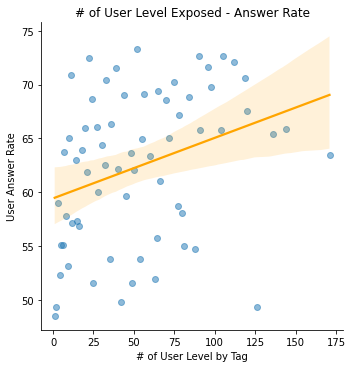

In [47]:
g = sns.lmplot(
    data=corr_user_ratio,
    x = 'userLVbyTag',
    y = 'userRatio',
    scatter_kws={'alpha':0.5},
    line_kws={"color": "orange"}
)
g.set_xlabels('# of User Level by Tag')
g.set_ylabels('User Answer Rate')
#g.set(xlim=(1, 120))

ax = plt.gca()
ax.set_title('# of User Level Exposed - Answer Rate')

In [2]:
import pandas as pd
userLVbyTag = pd.read_csv('/opt/ml/input/data/FE/userLVbyTag.csv')
userLVbyTagAVG = pd.read_csv('/opt/ml/input/data/FE/userLVbyTagAVG.csv')

In [4]:
userLVbyTag['userLVbyTag'].unique()

array([ 11.,  33.,  14.,  24.,  39.,  56.,  72.,  36.,  45.,  75.,  48.,
        40.,  60.,  55.,  20.,  54.,  25.,  30.,  50.,  65.,  66.,  84.,
        44.,  42.,  28.,  70.,  77.,  16.,  90.,  96.,  49.,  52.,  22.,
        91.,  63.,   4.,  78.,  80.,  98., 119., 112.,  64., 105.,  27.,
        35.,  18.,  21.,  32.,  12.,   9., 136.,  10.,  15.,   8., 144.,
        81., 171.,   6., 120., 104.,   1.,   3., 126.,   2.,   7.,  nan,
        88.,   5.])

In [8]:
userLVbyTagAVG

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,dataset,userLVbyTagAVG
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,49.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,49.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,1,49.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,1,49.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,1,49.0
...,...,...,...,...,...,...,...,...
2526695,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,1,38.0
2526696,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1,38.0
2526697,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,1,38.0
2526698,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,1,38.0


In [10]:
len(userLVbyTagAVG['userLVbyTagAVG'].unique())

72